In [1]:
#!pip install pmdarima
#!pip install numpy --upgrade 

In [2]:
#!pip install TextBlob

### Imports

In [315]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import regex as re
#sentiment analyser imports
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


#auto_arima 

from pmdarima import auto_arima

#accuracy check imports
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.feature_selection import mutual_info_regression
#saving model
import pickle

#LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation,GRU
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
print('...................done')


...................done


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\saket\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### sentiment dataset

In [4]:
news=pd.read_csv('C:/Users/saket/Desktop/PROJECTS/datasets/news.csv')                    

In [5]:
news.shape

(3424067, 3)

In [6]:
news.dtypes

publish_date          int64
headline_category    object
headline_text        object
dtype: object

In [7]:
news=news.loc[news['publish_date'] >= 20070917]
news.reset_index()

,index,publish_date,headline_category,headline_text
0,507527,20070917,delhi-times,Men are painting it pink
1,507528,20070917,delhi-times,Bipasha's twins!
2,507529,20070917,delhi-times,Come; be a part of the good times
3,507530,20070917,delhi-times,Style mantras of the art world
4,507531,20070917,delhi-times,A lesson in sensuality
...,...,...,...,...
2916535,3424062,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
2916536,3424063,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
2916537,3424064,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
2916538,3424065,20201231,removed,Govt extends deadline for use of FASTag till F...


In [8]:
news.shape

(2916540, 3)

In [9]:
news['headline_text']=news['headline_text'].astype('str')
news['headline_text']=news['headline_text'].str.lower()
news.dtypes

publish_date          int64
headline_category    object
headline_text        object
dtype: object

In [10]:
#remove unwanted columns
def col_remover(df,col):
  df.drop(col,axis=1,inplace=True)
col_remover(news,'headline_category')

In [11]:
#preprocess date column
news['publish_date']=news['publish_date'].astype('str')
news['publish_date']=news['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])

In [12]:
news=news.groupby(['publish_date'])['headline_text'].apply(lambda x:','.join(x)).reset_index()

In [13]:
news.head()

,publish_date,headline_text
0,2007-09-17,"men are painting it pink,bipasha's twins!,come..."
1,2007-09-18,"reel bonhomie,it's all about having fun togeth..."
2,2007-09-19,"dressed to thrill? not reely,i am a very posit..."
3,2007-09-20,"hey juniors! are you ready to rock?,saawariya'..."
4,2007-09-21,"yoga for face,priyanka chopra tears abs muscle..."


In [14]:
news.set_index('publish_date',drop=True,inplace=True)

In [15]:
news.head()

,headline_text
publish_date,
2007-09-17,"men are painting it pink,bipasha's twins!,come..."
2007-09-18,"reel bonhomie,it's all about having fun togeth..."
2007-09-19,"dressed to thrill? not reely,i am a very posit..."
2007-09-20,"hey juniors! are you ready to rock?,saawariya'..."
2007-09-21,"yoga for face,priyanka chopra tears abs muscle..."


### sentiment analysis

In [16]:
#apply vader analyzer on entire news dataset
sid=SentimentIntensityAnalyzer()
news['scores']=news['headline_text'].apply(lambda x:sid.polarity_scores(x))

In [17]:
#create separate columns for scores
news['compound']=news['scores'].apply(lambda x:x['compound'])
news['negative']=news['scores'].apply(lambda x:x['neg'])
news['positive']=news['scores'].apply(lambda x:x['pos'])
news['neutral']=news['scores'].apply(lambda x:x['neu'])
news.head()

,headline_text,scores,compound,negative,positive,neutral
publish_date,,,,,,
2007-09-17,"men are painting it pink,bipasha's twins!,come...","{'neg': 0.107, 'neu': 0.822, 'pos': 0.07, 'com...",-0.9964,0.107,0.070,0.822
2007-09-18,"reel bonhomie,it's all about having fun togeth...","{'neg': 0.127, 'neu': 0.794, 'pos': 0.079, 'co...",-0.9977,0.127,0.079,0.794
2007-09-19,"dressed to thrill? not reely,i am a very posit...","{'neg': 0.096, 'neu': 0.831, 'pos': 0.073, 'co...",-0.9892,0.096,0.073,0.831
2007-09-20,"hey juniors! are you ready to rock?,saawariya'...","{'neg': 0.115, 'neu': 0.802, 'pos': 0.084, 'co...",-0.9926,0.115,0.084,0.802
2007-09-21,"yoga for face,priyanka chopra tears abs muscle...","{'neg': 0.14, 'neu': 0.803, 'pos': 0.057, 'com...",-0.9989,0.140,0.057,0.803


In [18]:
col_remover(news,'headline_text')
col_remover(news,'scores')


In [33]:
news.shape

(4855, 4)

### numerical analysis

In [19]:
nifty_data=pd.read_csv('C:/Users/saket/Desktop/PROJECTS/datasets/nifty50.csv',index_col='Date')

In [34]:
nifty_data.shape

(3315, 6)

In [20]:
nifty_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0.0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0.0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0.0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0.0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0


In [21]:
nifty_data.isnull().sum()

Open         35
High         35
Low          35
Close        35
Adj Close    35
Volume       35
dtype: int64

In [22]:
#drop missing value rows
nifty_data.dropna(axis='rows',inplace=True)

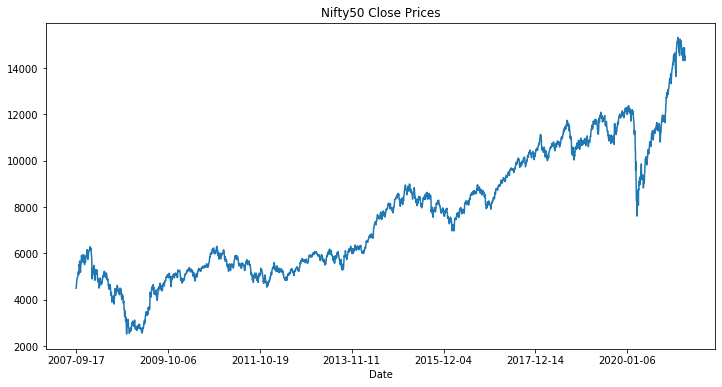

In [23]:
nifty_data['Close'].plot(figsize=(12,6),title='Nifty50 Close Prices')

### ARIMA on nifty

In [82]:
features=['Open', 'High', 'Low']
window1=3
window2=5
for feature in features:
    nifty_data[feature+'rolling_mean_3']=nifty_data[feature].rolling(window=window1).mean()
    nifty_data[feature+'rolling_mean_5']=nifty_data[feature].rolling(window=window2).mean()
for feature in features:
    nifty_data[feature+'rolling_stnd_3']=nifty_data[feature].rolling(window=window1).std()
    nifty_data[feature+'rolling_stnd_5']=nifty_data[feature].rolling(window=window2).std()
nifty_data.head()

,Open,High,Low,Close,Adj Close,Volume,Openrolling_mean_3,Openrolling_mean_5,Highrolling_mean_3,Highrolling_mean_5,Lowrolling_mean_3,Lowrolling_mean_5,Openrolling_stnd_3,Openrolling_stnd_5,Highrolling_stnd_3,Highrolling_stnd_5,Lowrolling_stnd_3,Lowrolling_stnd_5
Date,,,,,,,,,,,,,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0.0,4520.933431,NaN,4613.283203,NaN,4504.883301,NaN,28.157197,NaN,108.882622,NaN,39.294093,NaN
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0.0,4593.066732,NaN,4683.883301,NaN,4584.316569,NaN,125.956719,NaN,114.908199,NaN,123.379293,NaN
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0,4679.350098,4610.120117,4785.183431,4691.279981,4668.366699,4593.9,112.169647,123.901624,62.038836,135.863305,102.484357,125.096564


In [83]:
nifty_data.dropna(inplace=True)
nifty_data.isna().sum()

Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
Openrolling_mean_3    0
Openrolling_mean_5    0
Highrolling_mean_3    0
Highrolling_mean_5    0
Lowrolling_mean_3     0
Lowrolling_mean_5     0
Openrolling_stnd_3    0
Openrolling_stnd_5    0
Highrolling_stnd_3    0
Highrolling_stnd_5    0
Lowrolling_stnd_3     0
Lowrolling_stnd_5     0
dtype: int64

In [112]:
train_size=int(len(nifty_data)*0.6)
test_size=len(nifty_data)-train_size

train_data=nifty_data[:train_size]
test_data=nifty_data[train_size:]

In [113]:
ind_features=['Openrolling_mean_3',
'Openrolling_mean_5',    
'Highrolling_mean_3',    
'Highrolling_mean_5',    
'Lowrolling_mean_3',     
'Lowrolling_mean_5',     
'Openrolling_stnd_3',    
'Openrolling_stnd_5',    
'Highrolling_stnd_3',    
'Highrolling_stnd_5',    
'Lowrolling_stnd_3',     
'Lowrolling_stnd_5']

In [114]:
arima_model=auto_arima(y=train_data['Close'],
                       exogenous=train_data[ind_features],
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=20959.360, Time=8.91 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=21361.611, Time=1.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20933.279, Time=6.51 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20937.148, Time=4.94 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21427.823, Time=6.45 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=20899.265, Time=5.53 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=20929.268, Time=11.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=20901.056, Time=6.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=20923.532, Time=5.32 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=20963.765, Time=11.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=20990.775, Time=0.56 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 67.687 seconds


In [115]:
arima_model.fit(train_data['Close'],train_data[ind_features])

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True)

In [116]:
forecast=arima_model.predict(n_periods=len(test_data),exogenous=test_data[ind_features])

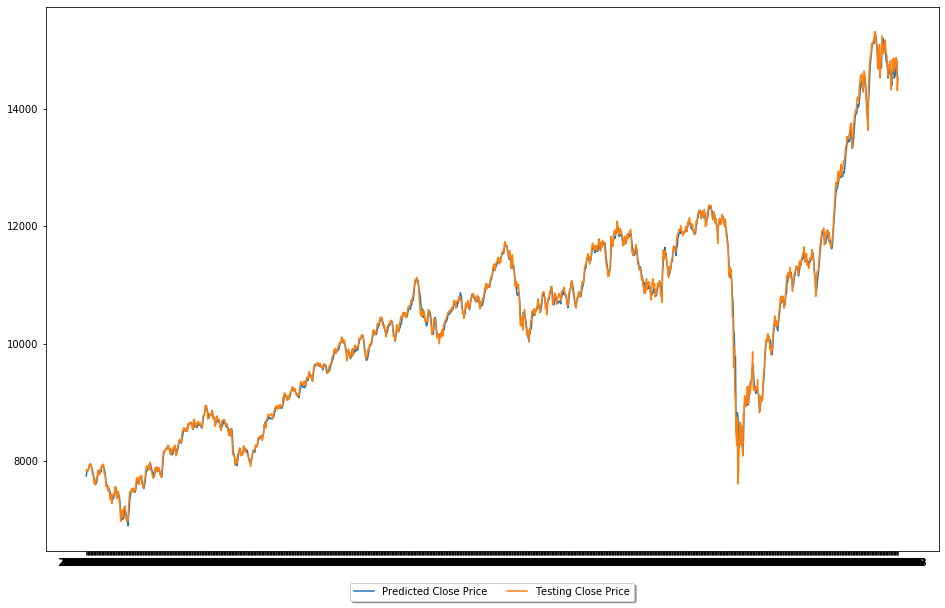

In [117]:
# plotting
plt.figure(figsize=(16,10))

plt.plot(forecast, label="Predicted Close Price")
plt.plot(test_data['Close'], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

In [118]:
MAE=mean_absolute_error(test_data['Close'],forecast)
RMSE=np.sqrt(mean_squared_error(test_data['Close'],forecast))
print('MAE:{}'.format(MAE))
print('RMSE:{}'.format(RMSE))

MAE:61.04518502014868
RMSE:91.11557594080205


### merging dataframes

In [27]:
merge=pd.concat([news,nifty_data],axis=1)


In [28]:
merge.head()

,compound,negative,positive,neutral,Open,High,Low,Close,Adj Close,Volume
2007-09-17,-0.9964,0.107,0.070,0.822,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0.0
2007-09-18,-0.9977,0.127,0.079,0.794,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0.0
2007-09-19,-0.9892,0.096,0.073,0.831,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0.0
2007-09-20,-0.9926,0.115,0.084,0.802,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0.0
2007-09-21,-0.9989,0.140,0.057,0.803,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0


In [29]:
merge.isna().sum()

compound       68
negative       68
positive       68
neutral        68
Open         1608
High         1608
Low          1608
Close        1608
Adj Close    1608
Volume       1608
dtype: int64

In [30]:
merge.dropna(inplace=True)

In [31]:
merge.shape

(3247, 10)

### features for model

In [42]:
data=merge[['compound','positive','negative','Open','High','Low','Close']]

In [43]:
data.head()

,compound,positive,negative,Open,High,Low,Close
2007-09-17,-0.9964,0.070,0.107,4518.450195,4549.049805,4482.850098,4494.649902
2007-09-18,-0.9977,0.079,0.127,4494.100098,4551.799805,4481.549805,4546.200195
2007-09-19,-0.9892,0.073,0.096,4550.250000,4739.000000,4550.250000,4732.350098
2007-09-20,-0.9926,0.084,0.115,4734.850098,4760.850098,4721.149902,4747.549805
2007-09-21,-0.9989,0.057,0.140,4752.950195,4855.700195,4733.700195,4837.549805


In [49]:
def shifter(df,col):
    df['shifted_'+col]=df[col].shift(-1)

In [50]:
#shift by 1 so taht we can predict for the next day
shifter(data,'compound')
shifter(data,'positive')
shifter(data,'negative')
shifter(data,'Close')

In [217]:
data.head()

,compound,positive,negative,Open,High,Low,Close,shifted_close,shifted_sentiment,shifted_compound,shifted_positive,shifted_negative,shifted_Close
2007-09-17,-0.9964,0.070,0.107,4518.450195,4549.049805,4482.850098,4494.649902,4546.200195,-0.9977,-0.9977,0.079,0.127,4546.200195
2007-09-18,-0.9977,0.079,0.127,4494.100098,4551.799805,4481.549805,4546.200195,4732.350098,-0.9892,-0.9892,0.073,0.096,4732.350098
2007-09-19,-0.9892,0.073,0.096,4550.250000,4739.000000,4550.250000,4732.350098,4747.549805,-0.9926,-0.9926,0.084,0.115,4747.549805
2007-09-20,-0.9926,0.084,0.115,4734.850098,4760.850098,4721.149902,4747.549805,4837.549805,-0.9989,-0.9989,0.057,0.140,4837.549805
2007-09-21,-0.9989,0.057,0.140,4752.950195,4855.700195,4733.700195,4837.549805,4932.200195,-0.9968,-0.9968,0.083,0.119,4932.200195


In [218]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
data.dropna(inplace=True)

In [465]:
# setting the target variable as the shifted close_price
y = data['shifted_Close']
y

2007-09-17     4546.200195
2007-09-18     4732.350098
2007-09-19     4747.549805
2007-09-20     4837.549805
2007-09-21     4932.200195
                  ...     
2020-12-23    13749.250000
2020-12-24    13873.200195
2020-12-28    13932.599609
2020-12-29    13981.950195
2020-12-30    13981.750000
Name: shifted_Close, Length: 3246, dtype: float64

In [466]:
# setting the features dataset for prediction  
cols = ['Close', 'compound', 'shifted_compound','Open', 'High', 'Low']
x = data[cols]
x

,Close,compound,shifted_compound,Open,High,Low
2007-09-17,4494.649902,-0.9964,-0.9977,4518.450195,4549.049805,4482.850098
2007-09-18,4546.200195,-0.9977,-0.9892,4494.100098,4551.799805,4481.549805
2007-09-19,4732.350098,-0.9892,-0.9926,4550.250000,4739.000000,4550.250000
2007-09-20,4747.549805,-0.9926,-0.9989,4734.850098,4760.850098,4721.149902
2007-09-21,4837.549805,-0.9989,-0.9968,4752.950195,4855.700195,4733.700195
...,...,...,...,...,...,...
2020-12-23,13601.099609,-0.9995,-0.9965,13473.500000,13619.450195,13432.200195
2020-12-24,13749.250000,-0.9965,-0.9997,13672.150391,13771.750000,13626.900391
2020-12-28,13873.200195,-0.9997,-0.9997,13815.150391,13885.299805,13811.549805
2020-12-29,13932.599609,-0.9997,-0.9997,13910.349609,13967.599609,13859.900391


In [467]:
# scaling the feature dataset
scaler_x = MinMaxScaler(feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.65604941, -0.9964    , -0.9977    , -0.65611298, -0.65583572,
         -0.61590395],
        [-0.64705109, -0.9977    , -0.9892    , -0.66037473, -0.65535376,
         -0.61612791],
        [-0.61455781, -0.9892    , -0.9926    , -0.6505474 , -0.62254529,
         -0.60429549],
        ...,
        [ 0.98101722, -0.9997    , -0.9997    ,  0.97099052,  0.98042357,
          0.99080271],
        [ 0.99138564, -0.9997    , -0.9997    ,  0.98765224,  0.99484732,
          0.99913026],
        [ 1.        , -0.9997    , -0.9996    ,  1.        ,  1.        ,
          1.        ]]), array([[-0.64705109],
        [-0.61455781],
        [-0.61190464],
        ...,
        [ 0.99138564],
        [ 1.        ],
        [ 0.99996506]]))

In [468]:
train_size=int(len(data)*0.7)
test_size=len(data)-train_size

train_data=data[:train_size]
test_data=data[train_size+1:]

In [469]:
# preparing training and test dataset
X_train = x[0 : train_size,]
X_test = x[train_size+1 : len(x),]    
y_train = y[0 : train_size] 
y_test = y[train_size+1 : len(y)]  

In [470]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

In [471]:
#early stoppping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)

In [472]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(128,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(128,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(128,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 6, 128)            66560     
_________________________________________________________________
dropout_103 (Dropout)        (None, 6, 128)            0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 6, 128)            131584    
_________________________________________________________________
dropout_104 (Dropout)        (None, 6, 128)            0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_105 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

In [473]:
# compiling the model
model.compile(loss='mae' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=8, verbose=1,callbacks=es)

Epoch 1/20
228/228 [==============================] - 8s 18ms/step - loss: 0.1435 - val_loss: 0.1198
Epoch 2/20
228/228 [==============================] - 3s 13ms/step - loss: 0.0759 - val_loss: 0.1251
Epoch 3/20
228/228 [==============================] - 3s 14ms/step - loss: 0.0565 - val_loss: 0.0221
Epoch 4/20
228/228 [==============================] - 4s 19ms/step - loss: 0.0351 - val_loss: 0.0297
Epoch 5/20
228/228 [==============================] - 6s 24ms/step - loss: 0.0331 - val_loss: 0.0230
Epoch 6/20
228/228 [==============================] - 4s 18ms/step - loss: 0.0329 - val_loss: 0.0138
Epoch 7/20
228/228 [==============================] - 3s 13ms/step - loss: 0.0259 - val_loss: 0.0140
Epoch 8/20
228/228 [==============================] - 3s 13ms/step - loss: 0.0229 - val_loss: 0.0178
Epoch 9/20
228/228 [==============================] - 3s 13ms/step - loss: 0.0250 - val_loss: 0.0133
Epoch 10/20
228/228 [==============================] - 3s 13ms/step - loss: 0.0284 - val_lo

In [474]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions),1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[8317.222],
       [8326.259],
       [8342.27 ],
       [8342.789],
       [8298.265]], dtype=float32)

In [475]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

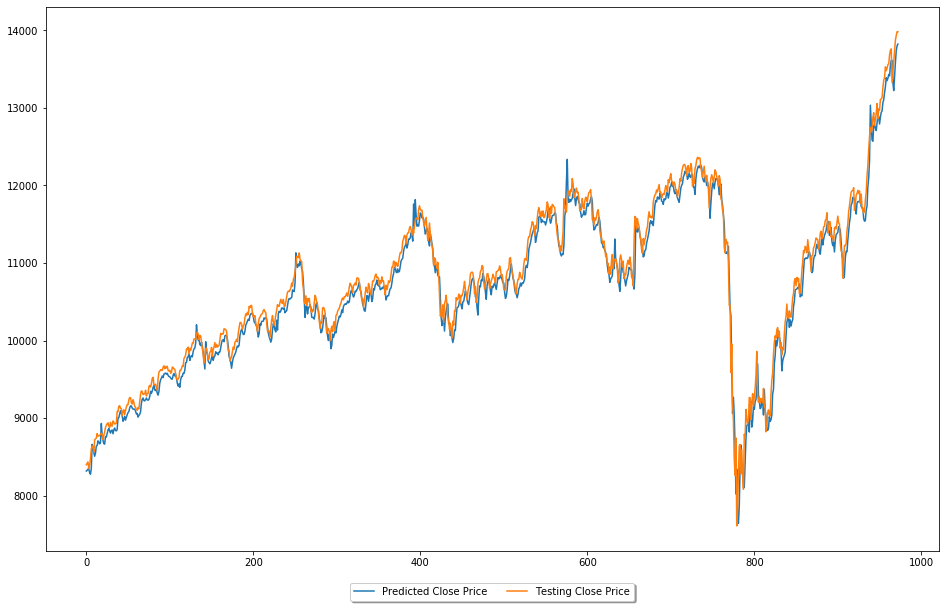

In [476]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

In [493]:
mae=mean_absolute_error(y_test, predictions)
rmse = np.sqrt((mean_squared_error(y_test, predictions)))
print('RMSE:{}'.format(rmse))
print('MAE:{}'.format(mae))

RMSE:10704.406830237405
MAE:10652.322814820693
